# XGBoost model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division
from __future__ import print_function

from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterSampler
from sklearn.decomposition import PCA


from lib import utils
from lib import xgb_utils
from lib import cols
from lib import preprocess

np.random.seed(seed=13)
# modify font size
sns.set(font_scale=1.25)

/home/akiyuki/.pyenv/versions/miniconda2-4.1.11/envs/mle-capstone/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing

In [3]:
ds_sj, ds_iq = preprocess.preprocess()

lib/utils.py:184: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_iq = df_dev_iq[is_train_iq]
lib/utils.py:185: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_valid_iq = df_dev_iq[is_valid_iq]
lib/utils.py:186: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_devtest_iq = df_dev_iq[is_devtest_iq]


sj train: 675 lines	 valid: 156 lines	 devtest: 105 lines	 test: 260 lines
iq train: 363 lines	 valid: 104 lines	 devtest: 53 lines	 test: 156 lines
sj valid: 0.19%
iq valid: 0.22%


## Define Models

In [4]:
def train_ds(ds, col_target, col_feats, model_params, train_params={"verbose":True, "eval_metric": "mae"}, search_iter=50):
    fmap = {"f{0:d}".format(i): fname for i, fname in enumerate(col_feats)}

    X = ds.df_train[col_feats].values
    y = ds.df_train[col_target].values

    X_val = ds.df_valid[col_feats].values
    y_val = ds.df_valid[col_target].values
    res = train(X, y, X_val, y_val, model_params=model_params, train_params=train_params)
    return res, fmap

def train(X, y, X_val, y_val, model_params, train_params={"verbose":True, "eval_metric": "mae"}, search_iter=50):

    best_model = None
    for param in ParameterSampler(model_params, n_iter=search_iter):
        model = xgb.XGBRegressor(**param)
        res = model.fit(X, y, eval_metric=train_params["eval_metric"], eval_set=[(X, y),  (X_val, y_val)], early_stopping_rounds=5, verbose=train_params["verbose"])
        
        if (best_model is None) or (res.best_score < best_model.best_score):
            best_model = res
    #print("best_score: {0}".format(res.best_score))
    
    return best_model

## Default Model Result

In [5]:
np.random.seed(seed=13)
model_params = dict(
    learning_rate=[0.001, 0.005, 0.01, 0.05], 
    max_depth=[2, 3, 4],
    n_estimators=[500],
    reg_lambda=np.random.uniform(0.5, 1.0, 100),
    colsample_bytree=np.random.uniform(0.5, 1.0, 100),
    objective = ["reg:linear"])

metric = "mae"
col_feats = cols.orig_feats
train_params = dict(verbose=False, eval_metric=metric)
model_sj, fmap_sj = train_ds(ds_sj, cols.target, col_feats, model_params=model_params, train_params=train_params)
model_iq, fmap_iq = train_ds(ds_iq, cols.target, col_feats, model_params=model_params, train_params=train_params)

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.50492272039984432,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 0.88885120528691008,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
8.767271
{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.83462370531972363,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 0.5175182620507186,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
valid_score: 13.083905165	devtest_score: 16.3030961173
valid_score: 8.77848854088	devtest_score: 5.09387934883


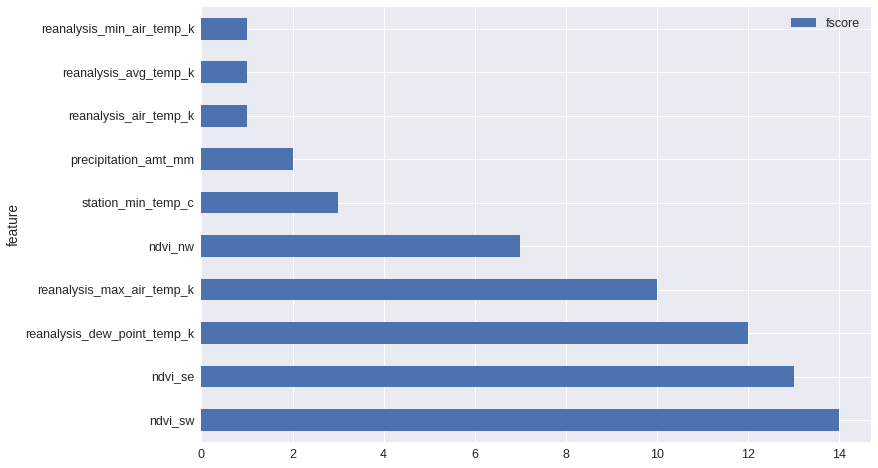

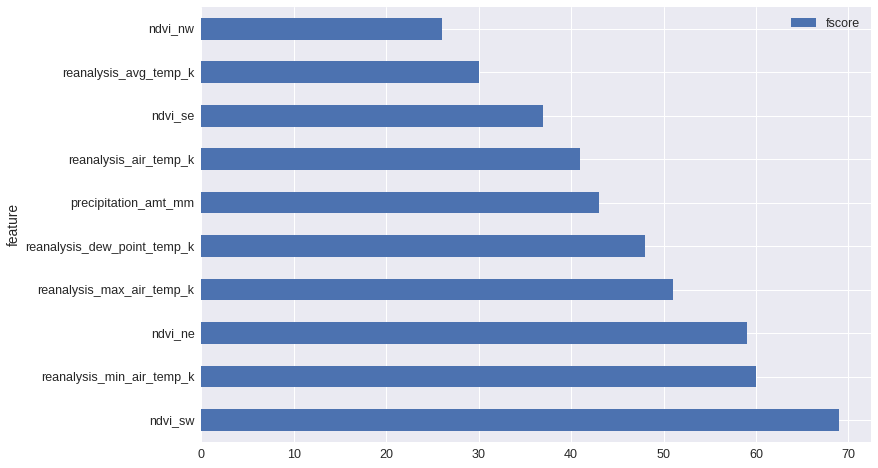

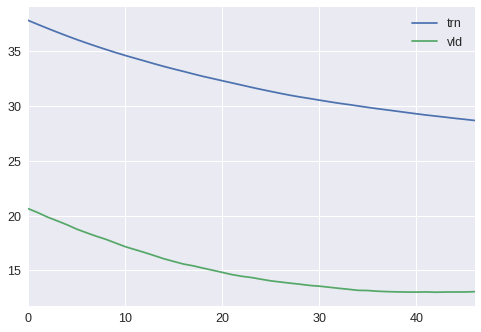

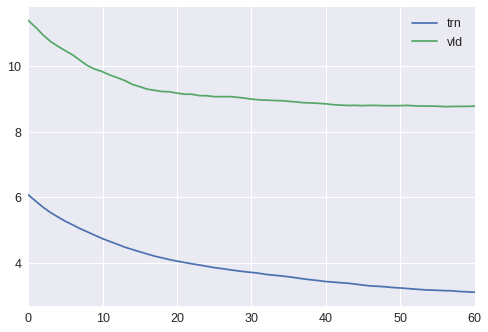

In [6]:
#print(model_sj.best_score)
pprint(model_sj.get_params())
print(model_iq.best_score)
pprint(model_iq.get_params())

xgb_utils.plot_fscore(model_sj, fmap_sj, "./img/fscore_sj.svg")
xgb_utils.plot_fscore(model_iq, fmap_iq, "./img/fscore_iq.svg")

xgb_utils.plot_hist(model_sj, metric)
xgb_utils.plot_hist(model_iq, metric)

_ = xgb_utils.get_scores(model_sj, ds_sj, cols.target, col_feats)
_ = xgb_utils.get_scores(model_iq, ds_iq, cols.target, col_feats)

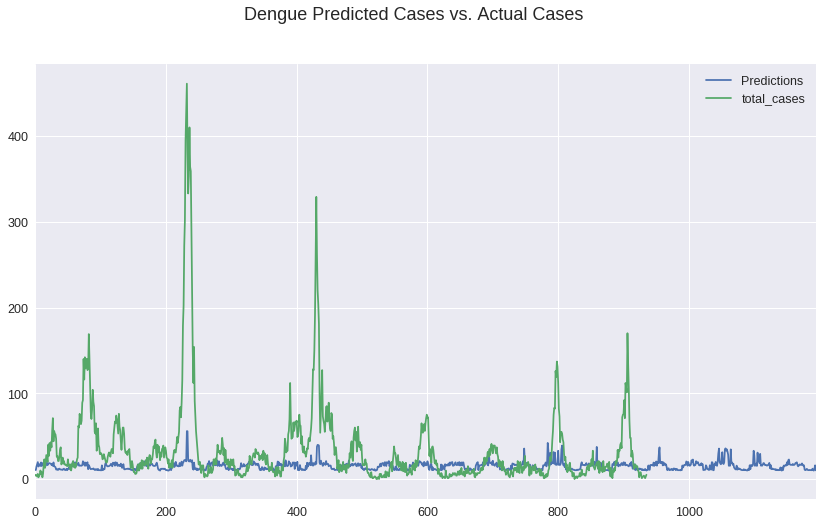

In [7]:
xgb_utils.plot_predict(model_sj, ds_sj.df_all, cols.target, col_feats)

In [8]:
xgb_utils.save_result(model_sj, model_iq, col_feats, col_feats, ds_sj.df_test, ds_iq.df_test, "Xgboost")

## PCA Result

In [9]:
np.random.seed(seed=13)
model_params = dict(
    learning_rate=[0.001, 0.005, 0.01, 0.05], 
    max_depth=[2, 3, 4],
    n_estimators=[500],
    reg_lambda=np.random.uniform(0.5, 1.0, 100),
    colsample_bytree=np.random.uniform(0.5, 1.0, 100),
    objective = ["reg:linear"])
train_params = dict(verbose=False, eval_metric=metric)

col_feats = cols.get_pca_feats(7)
model_sj, fmap_sj = train_ds(ds_sj, cols.target, col_feats, model_params=model_params, train_params=train_params)
model_iq, fmap_iq = train_ds(ds_iq, cols.target, col_feats, model_params=model_params, train_params=train_params)

12.753093
{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.66714412619031138,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 0.60081703755705762,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
9.271068
{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.50660031278244977,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 0.50470638504048471,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
valid_score: 13.4502581694	devtest_score: 16.6441908064
valid_score: 9.29987957615	devtest_score: 4.07318534041


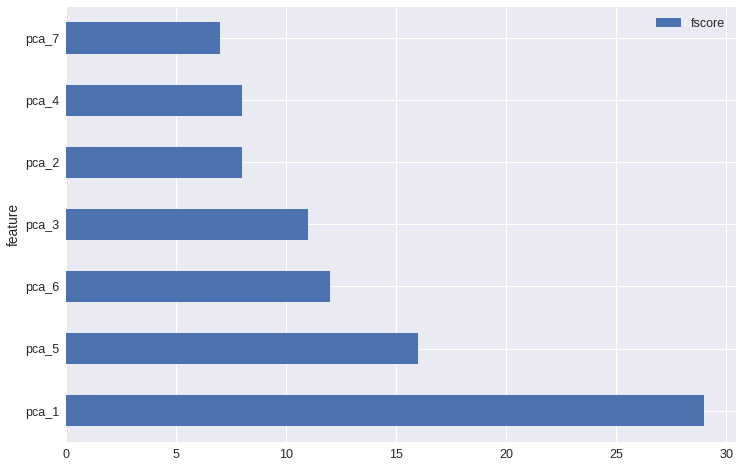

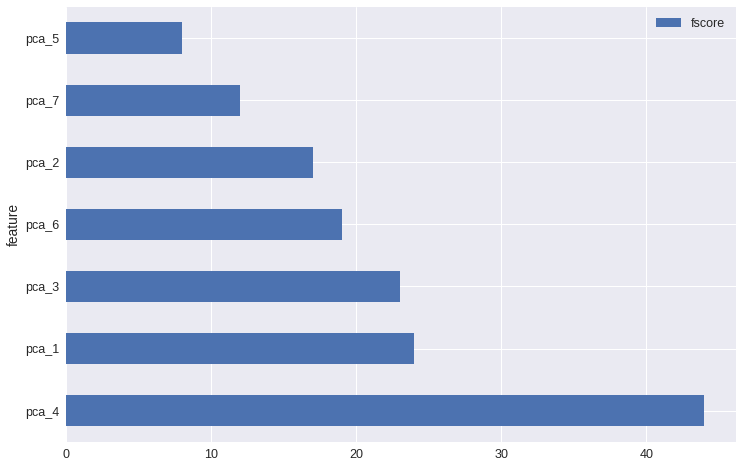

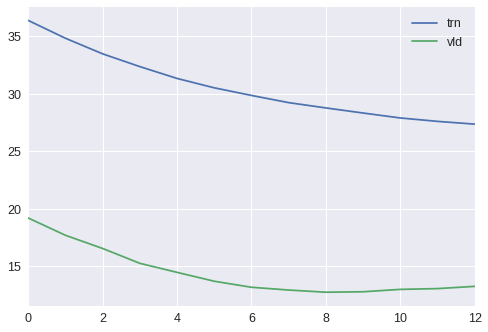

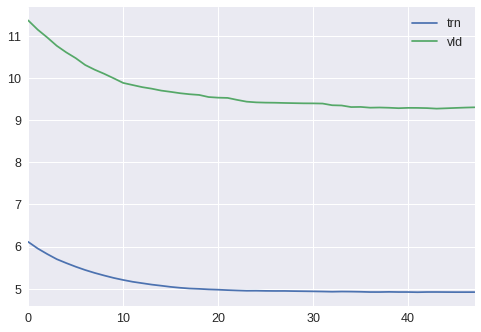

In [10]:
print(model_sj.best_score)
pprint(model_sj.get_params())
print(model_iq.best_score)
pprint(model_iq.get_params())

xgb_utils.plot_fscore(model_sj, fmap_sj, "./img/fscore_pca_sj.svg")
xgb_utils.plot_fscore(model_iq, fmap_iq, "./img/fscore_pca_iq.svg")

xgb_utils.plot_hist(model_sj, metric)
xgb_utils.plot_hist(model_iq, metric)

_ = xgb_utils.get_scores(model_sj, ds_sj, cols.target, col_feats)
_ = xgb_utils.get_scores(model_iq, ds_iq, cols.target, col_feats)

In [11]:
xgb_utils.save_result(model_sj, model_iq, col_feats, col_feats, ds_sj.df_test, ds_iq.df_test, "Xgboost(PCA)")

## Add Rolling average (RMSE)

In [12]:
np.random.seed(seed=13)
model_params = dict(
    learning_rate=[0.001, 0.005, 0.01, 0.05], 
    max_depth=[2, 3, 4, 5],
    n_estimators=[500],
    reg_lambda=np.random.uniform(0.5, 2.0, 100),
    reg_alpha=np.random.uniform(0.0, 1.0, 100),
    colsample_bytree=np.random.uniform(0.4, 1.0, 100),
    objective = ["reg:linear"])

metric = "rmse"

col_roll_feats = cols.get_roll_feats(cols.orig_feats, 4)
col_roll_lag_feats = cols.get_lag_feats(col_roll_feats, [4, 8, 12, 16, 20])
col_feats = cols.orig_feats + col_roll_feats + col_roll_lag_feats

train_params = dict(verbose=False, eval_metric=metric)
model_sj, fmap_sj = train_ds(ds_sj, cols.target, col_feats, model_params=model_params, train_params=train_params, search_iter=200)
model_iq, fmap_iq = train_ds(ds_iq, cols.target, col_feats, model_params=model_params, train_params=train_params)

21.264856
{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.49304727338172039,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0.91330124402687751,
 'reg_lambda': 1.4624200171386037,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
12.688817
{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.42584597685675757,
 'gamma': 0,
 'learning_rate': 0.005,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 500,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0.27886355130641083,
 'reg_lambda': 0.87948902423225972,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}
valid_score: 12.5460104881	devtest_score: 15.2879092807
valid_score: 8.26657548776	devtest_score: 3.46261740631


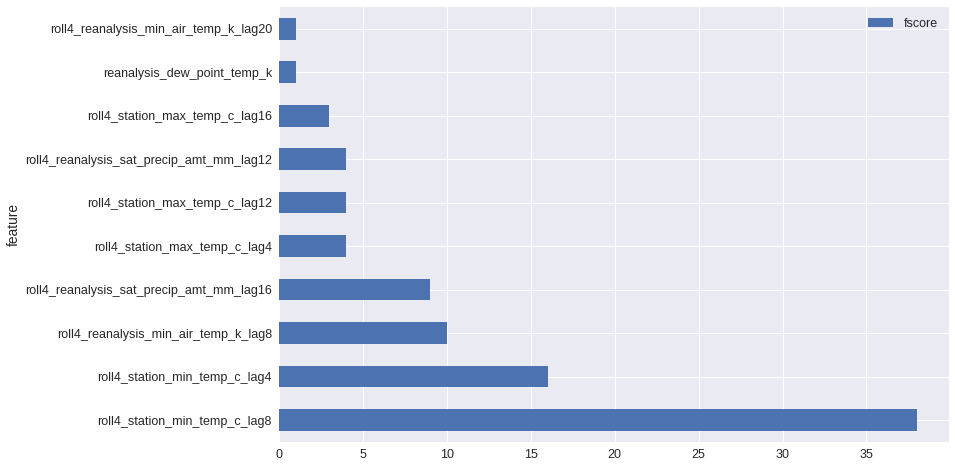

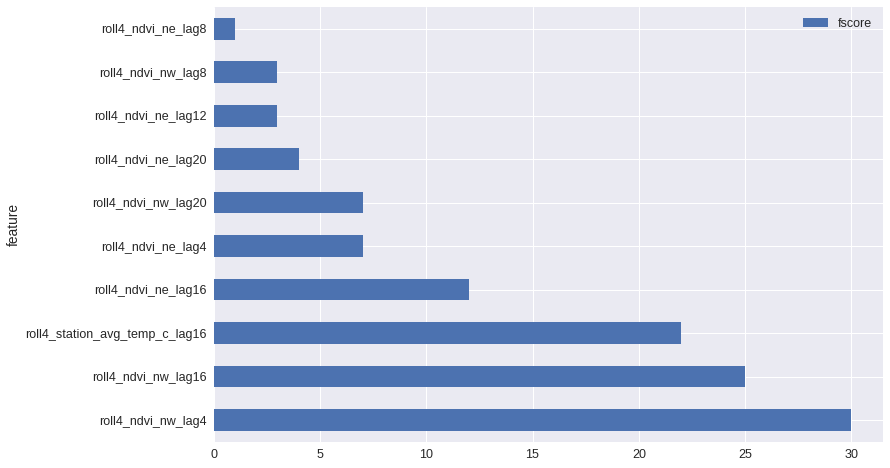

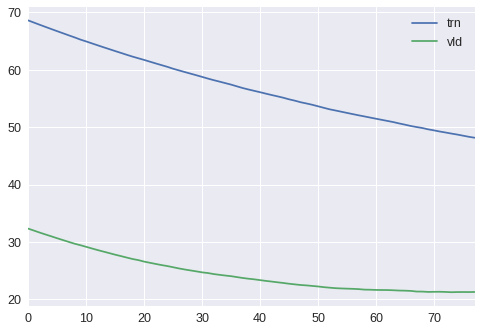

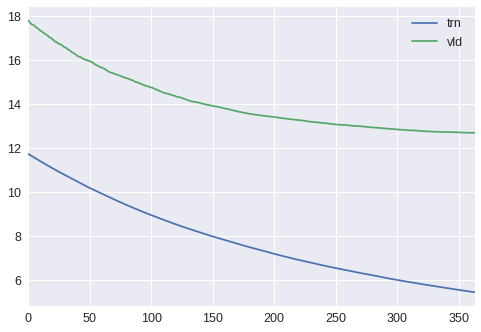

In [13]:
print(model_sj.best_score)
pprint(model_sj.get_params())
print(model_iq.best_score)
pprint(model_iq.get_params())

xgb_utils.plot_fscore(model_sj, fmap_sj, "./img/fscore_rmse_sj.svg")
xgb_utils.plot_fscore(model_iq, fmap_iq, "./img/fscore_rmse_iq.svg")

xgb_utils.plot_hist(model_sj, metric=metric)
xgb_utils.plot_hist(model_iq, metric=metric)

_ = xgb_utils.get_scores(model_sj, ds_sj, cols.target, col_feats)
_ = xgb_utils.get_scores(model_iq, ds_iq, cols.target, col_feats)

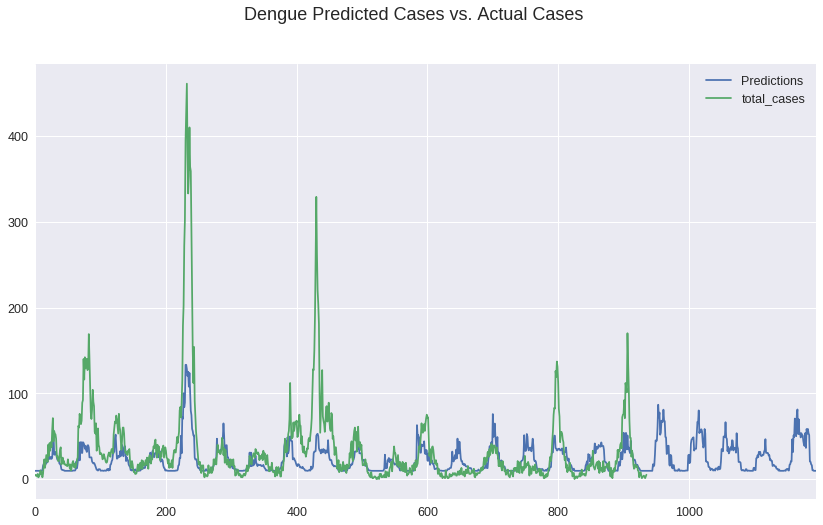

In [14]:
xgb_utils.plot_predict(model_sj, ds_sj.df_all, cols.target, col_feats)

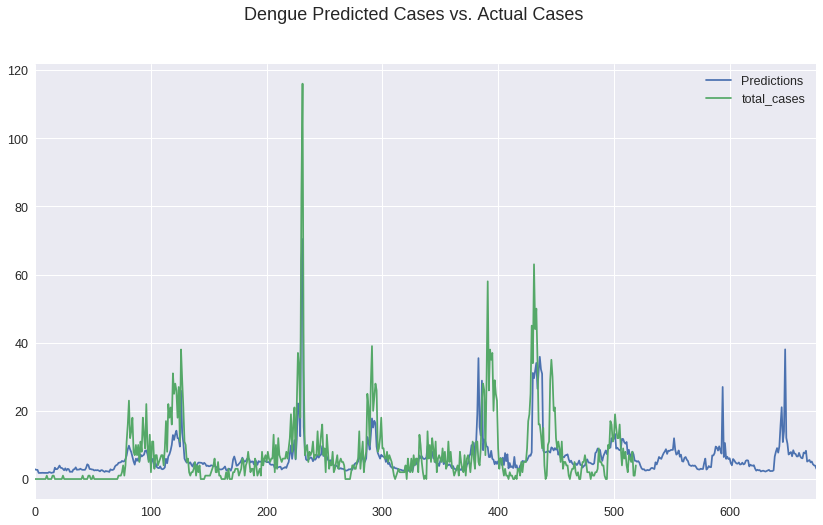

In [15]:
xgb_utils.plot_predict(model_iq, ds_iq.df_all, cols.target, col_feats)

In [ ]:
xgb_utils.save_result(model_sj, model_iq, col_feats, col_feats, ds_sj.df_test, ds_iq.df_test, "Xgboost(RMSE_Roll)")

## Add Rolling average (MAE)

In [ ]:
np.random.seed(seed=13)
model_params = dict(
    learning_rate=[0.001, 0.005, 0.01, 0.05], 
    max_depth=[2, 3, 4, 5],
    n_estimators=[500],
    reg_lambda=np.random.uniform(0.5, 2.0, 100),
    reg_alpha=np.random.uniform(0.0, 1.0, 100),
    colsample_bytree=np.random.uniform(0.4, 1.0, 100),
    objective = ["reg:linear"])

metric = "mae"
train_params = dict(verbose=False, eval_metric=metric)
model_sj, fmap_sj = train_ds(ds_sj, cols.target, col_feats, model_params=model_params, train_params=train_params, search_iter=100)
model_iq, fmap_iq = train_ds(ds_iq, cols.target, col_feats, model_params=model_params, train_params=train_params, search_iter=100)

In [ ]:
print(model_sj.best_score)
pprint(model_sj.get_params())
print(model_iq.best_score)
pprint(model_iq.get_params())

xgb_utils.plot_fscore(model_sj, fmap_sj, "./img/fscore_roll_sj.svg")
xgb_utils.plot_fscore(model_iq, fmap_iq, "./img/fscore_roll_iq.svg")

xgb_utils.plot_hist(model_sj, metric=metric)
xgb_utils.plot_hist(model_iq, metric=metric)

_ = xgb_utils.get_scores(model_sj, ds_sj, cols.target, col_feats)
_ = xgb_utils.get_scores(model_iq, ds_iq, cols.target, col_feats)

In [ ]:
xgb_utils.plot_predict(model_sj, ds_sj.df_all, cols.target, col_feats)

In [ ]:
xgb_utils.save_result(model_sj, model_iq, col_feats, col_feats, ds_sj.df_test, ds_iq.df_test, "Xgboost(Roll)")